In [1]:
from matplotlib import pyplot as plt
from scipy.signal import resample

from peakalignment.apply_alignment import apply_alignment
from peakalignment.density_filter import get_density_filtered_matches
from peakalignment.regression import get_regression_lines
from peakalignment.line_filter import get_filtered_lines
from plotting.plot_rpeak_detector import plot_artefacts_on_signal
from tests.add_noise import add_noise
from tests.rpeak_detector import neurokit_rpeak_detect_fast
from tests.generate_wfdb import get_records
from peakalignment.signal_matching import get_matches
from tests.calculate_true_offset import generate_true_line_data_from_scratch
import numpy as np

First thing we do is create some synthetic data. In this case, we're using an ECG record from MIT-BIH.

The main goal of our alignment algorithm is to take similar signals (R Peaks) record on different devices, whose
clocks behave in different ways, and provide a mapping function from one clock's time space to the other's.

To that end, we simulate the circumstances we encounter in our clinical devices. Clock A (the timekeeper for Signal A),
is given a synthetic clock drift of -420 ppm, in other words, the time reported by the clock will fall behind the true
time, (which we will keep track of). Every 10 minutes, we will simulate the clock resynchronizing with a server time,
creating a gap in otherwise continuous data.

Clock B will experience a drift of -20 ppm, but will not sync with the server.

In [2]:
# Set up raw data
records = get_records()
record = next(records)
signal_a = record.p_signal[:, 0]
signal_b = np.copy(signal_a)

# Signal A is resampled to 500 Hz and Signal B is resampled to 256 Hz to recreate the sample frequencies
# we encountered in our clinical environment.
freq_hz_a = 500  # Desired Signal A Freq
freq_hz_b = 256  # Desired Signal B Freq
original_freq_hz = record.fs

signal_a_new_num_values = (signal_a.size * freq_hz_a) // original_freq_hz
signal_a = resample(signal_a, signal_a_new_num_values)

signal_b_new_num_values = (signal_b.size * freq_hz_b) // original_freq_hz
signal_b = resample(signal_b, signal_b_new_num_values)

# Add Gaussian Noise 20% and 30% of the total mit-bih dataset std.
total_mit_bih_std = 0.47236843197533834
add_noise(signal_a, 0.20, seed=42, wave_std=total_mit_bih_std)
add_noise(signal_b, 0.30, seed=99, wave_std=total_mit_bih_std)

# Create Times
start_time_ms = 0
period_ms_b = 1000 / freq_hz_b
period_ms_a = 1000 / freq_hz_a

signal_a_signal_times = np.arange(start_time_ms, start_time_ms + (signal_a.size * period_ms_a), period_ms_a)
signal_b_signal_times = np.arange(start_time_ms, start_time_ms + (signal_b.size * period_ms_b), period_ms_b)

# Add Clock Drift
clock_drift_a = -420 / (10 ** 6)  # - 420 ppm
clock_drift_b = -20 / (10 ** 6)  # - 20 ppm

# Simulate Server Resynchronization.
signal_a_sync_dur = 600_000  # Sync every 10 min or 600k ms.
true_line_data, resampled_a_x, true_a_t, false_a_t, resampled_b_x, true_b_t, false_b_t = \
    generate_true_line_data_from_scratch(
        signal_a_signal_times, signal_a, signal_b_signal_times, signal_b, period_ms_a, period_ms_b,
        clock_drift_a, clock_drift_b, signal_a_sync_dur=signal_a_sync_dur, seed=None)

# Some magic to make the true offset have the same structure as the output of the algorithm.
true_line_data = [row + [None, None] for row in true_line_data]

Here we can see our two signals which we are attempting to align.

If you are using matplotlib backend that allows zooming, you can see the difference in the noise levels and the effect
of the clock drift.

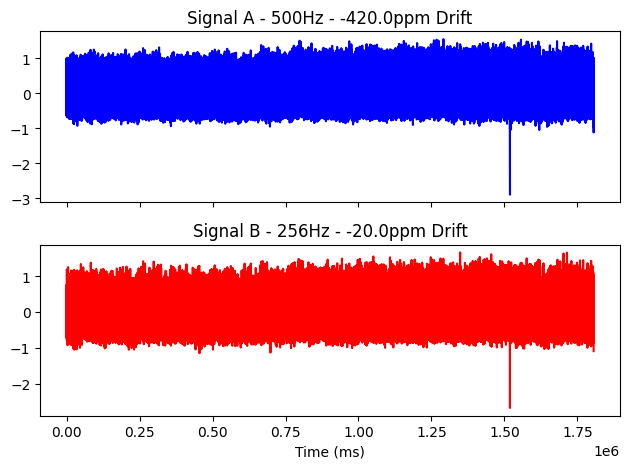

In [3]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(false_a_t, resampled_a_x, color='blue')
ax1.set_title(f'Signal A - {freq_hz_a}Hz - {(10**6)*clock_drift_a}ppm Drift')

ax2.plot(false_b_t, resampled_b_x, color='red')
ax2.set_title(f'Signal B - {freq_hz_b}Hz - {(10**6)*clock_drift_b}ppm Drift')

plt.xlabel('Time (ms)')

plt.tight_layout()
plt.show()

Here is a zoomed in example of the server resynchronizations. Notice that the signal is in reality continuous
between the gap, however, in catching up to the server's time, the synchronization creates a non-physical gap.

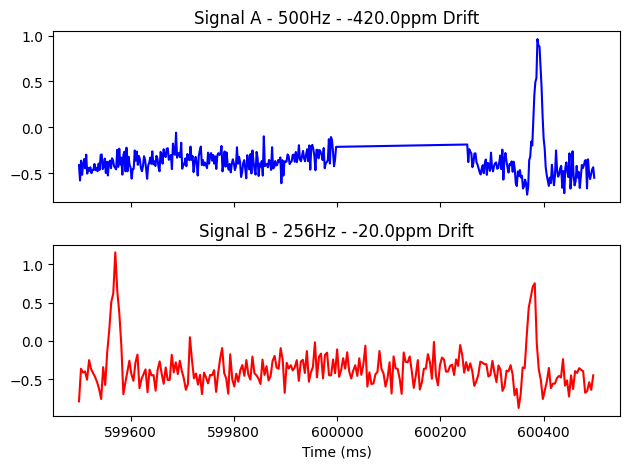

In [4]:
expected_first_gap_time = signal_a_sync_dur
expected_first_gap_index_a = np.searchsorted(false_a_t, expected_first_gap_time)
expected_first_gap_index_b = np.searchsorted(false_b_t, expected_first_gap_time)

time_span = 500  # 500 ms

left_a = np.searchsorted(false_a_t, expected_first_gap_time - time_span)
right_a = np.searchsorted(false_a_t, expected_first_gap_time + time_span)

left_b = np.searchsorted(false_b_t, expected_first_gap_time - time_span)
right_b = np.searchsorted(false_b_t, expected_first_gap_time + time_span)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(false_a_t[left_a:right_a],
         resampled_a_x[left_a:right_a],
         color='blue')
ax1.set_title(f'Signal A - {freq_hz_a}Hz - {(10**6)*clock_drift_a}ppm Drift')

ax2.plot(false_b_t[left_b: right_b]
         ,resampled_b_x[left_b: right_b],
         color='red')
ax2.set_title(f'Signal B - {freq_hz_b}Hz - {(10**6)*clock_drift_b}ppm Drift')

plt.xlabel('Time (ms)')

plt.tight_layout()
plt.show()

Below we use the neurokit2 library to rpeak detect our two signals.

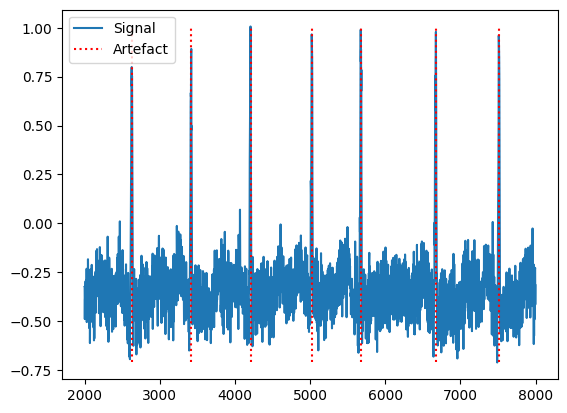

In [5]:
peak_indices_a = neurokit_rpeak_detect_fast(resampled_a_x, freq_hz_a)
peak_indices_b = neurokit_rpeak_detect_fast(resampled_b_x, freq_hz_b)

signal_a_peak_times = false_a_t[peak_indices_a]
signal_b_peak_times = false_b_t[peak_indices_b]

plot_artefacts_on_signal(false_a_t[1_000:4_000],
                         resampled_a_x[1_000:4_000],
                         [peak_t for peak_t in signal_a_peak_times if false_a_t[1_000] < peak_t < false_a_t[4_000]])

We use the euclidean distance between windows of 20 beats from the two signals, and plot the matches of smallest
euclidean distance, by the time of the match according to Clock A vs The Difference Between the two Time Recordings.

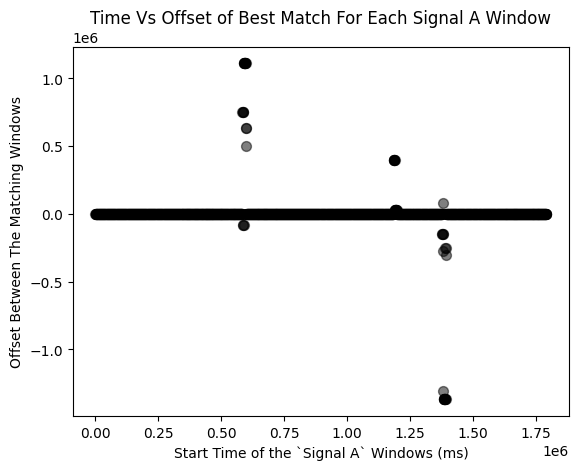

In [6]:
match_indices_matrix, match_distance_matrix = get_matches(signal_a_peak_times, signal_b_peak_times, max_offset=None)

offset_matrix = signal_b_peak_times[match_indices_matrix] - signal_a_peak_times[
                                                            :match_indices_matrix.shape[0]].reshape(-1, 1)

offset_t = signal_a_peak_times[np.repeat(np.arange(offset_matrix.shape[0]), offset_matrix.shape[1])]
offset_v = offset_matrix.ravel()

plt.title("Time Vs Offset of Best Match For Each Signal A Window")
plt.scatter(offset_t, offset_v, color='black', s=50, alpha=0.5)
plt.xlabel("Start Time of the `Signal A` Windows (ms)")
plt.ylabel("Offset Between The Matching Windows")
plt.show()

You can observe that most of the points lie around the offset of 0 ms, while outliers can be quite large, as windows
from signal A have the potential of matching with any windows from signal B, regardless of the offset in time between
them.

If we zoom in to +- 750 ms, You can see the bulk of the offsets. And the "signal of alignment", The slope of these
lines is a measurement of the relative clock drift between the two clocks, and the breaks correspond to the
resynchronization events.

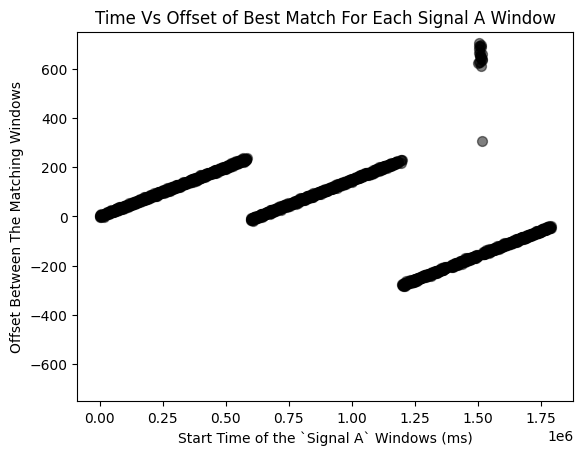

In [7]:
plt.title("Time Vs Offset of Best Match For Each Signal A Window")
plt.scatter(offset_t, offset_v, color='black', s=50, alpha=0.5)
plt.xlabel("Start Time of the `Signal A` Windows (ms)")
plt.ylabel("Offset Between The Matching Windows")
plt.ylim(-750, 750)
plt.show()

We have an algorithmic process that achieves a similar outcome to manually zooming in to the critical area of the
offset graph, like we did in the cell above.

The general idea is to look for areas on the plot where points are close together (dense), and only return points
that are of the highest density for each bin along the x-axis.

We call it, the density filter. As you can see, we didn't have to manually zoom the graph, yet all the key regions
are represented, and none of the outliers.

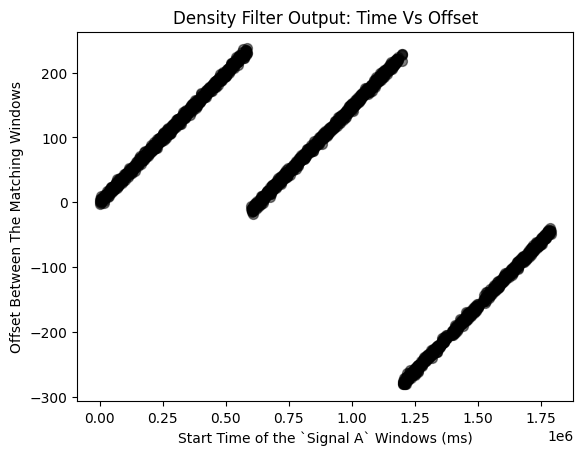

In [8]:
density_data = get_density_filtered_matches(signal_a_peak_times, signal_b_peak_times,
                                            match_indices_matrix,
                                            max_offset=None)
offset_t, offset_v = density_data['fine_offset_t'], density_data['fine_offset_v']


plt.title("Density Filter Output: Time Vs Offset")
plt.scatter(offset_t, offset_v, color='black', s=50, alpha=0.5)
plt.xlabel("Start Time of the `Signal A` Windows (ms)")
plt.ylabel("Offset Between The Matching Windows")
plt.show()

While we can easily see in this example where the different parts that make up the "signal of alignment" are located,
in general, it's not a simple task to algorithmically define the boundaries between these signals in order to run
separate regression models on each piece. Fortunately we don't need to.

We use a technique called Robust Linear Regression on the entire plot, which looks for tightly bound points along
a potential regression line, and ignores any points that don't lie within its "tolerance threshold".

The result of which looks like this:

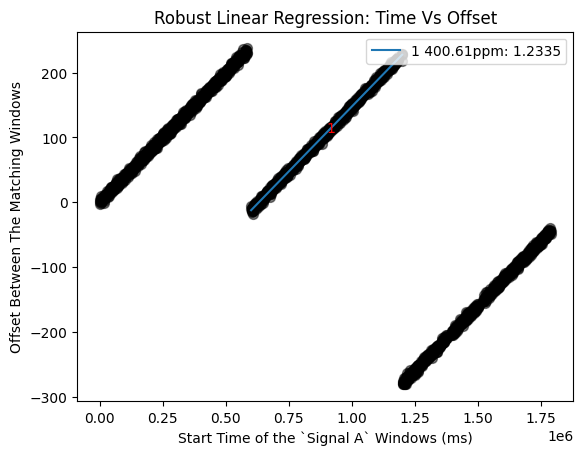

In [9]:
from peakalignment.constants import residual_threshold_ms, max_trials, min_line_inliers
from peakalignment.regression import get_one_line

# Run the Algorithm
coef_1, score_1, trimmed_inlier_mask_1, new_outlier_mask_1 = \
    get_one_line(offset_t, offset_v, residual_threshold=residual_threshold_ms,
                 max_trials=max_trials, min_line_inliers=min_line_inliers)

t_min_1 = int(np.min(offset_t[trimmed_inlier_mask_1]))
t_max_1 = int(np.max(offset_t[trimmed_inlier_mask_1]))

b_1, m_1 = coef_1
num_inliers_1 = np.count_nonzero(trimmed_inlier_mask_1)

line_x_1 = np.array([t_min_1, t_max_1])
line_y_1 = (m_1 * line_x_1) + b_1

# Plot the Result
plt.title("Robust Linear Regression: Time Vs Offset")
plt.scatter(offset_t, offset_v, color='black', s=50, alpha=0.5)
label_1 = f"1 {round(m_1 * (10 ** 6), 2)}ppm: {round(((10 ** 3) * num_inliers_1) / (t_max_1 - t_min_1), 4)}"
plt.plot(line_x_1, line_y_1, label=label_1)
av_x = np.mean(line_x_1)
av_y = np.mean(line_y_1)
plt.text(av_x, av_y, str(1), c='red')
plt.xlabel("Start Time of the `Signal A` Windows (ms)")
plt.ylabel("Offset Between The Matching Windows")
plt.legend(loc='upper right')
plt.show()

This gives us one of the pieces of the signal of alignment. To get the next one, we remove the inliers of this
first regression result, and rerun the algorithm.

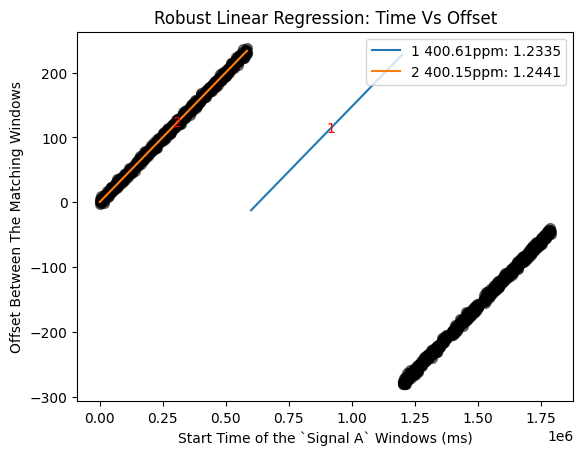

In [10]:
# Remove the inliers for the last result.
offset_t, offset_v = offset_t[new_outlier_mask_1], offset_v[new_outlier_mask_1]

# Rerun the Algorithm
coef_2, score_2, trimmed_inlier_mask_2, new_outlier_mask_2 = \
    get_one_line(offset_t, offset_v, residual_threshold=residual_threshold_ms,
                 max_trials=max_trials, min_line_inliers=min_line_inliers)

t_min_2 = int(np.min(offset_t[trimmed_inlier_mask_2]))
t_max_2 = int(np.max(offset_t[trimmed_inlier_mask_2]))

b_2, m_2 = coef_2
num_inliers_2 = np.count_nonzero(trimmed_inlier_mask_2)

line_x_2 = np.array([t_min_2, t_max_2])
line_y_2 = (m_2 * line_x_2) + b_2

# Plot the Result
plt.title("Robust Linear Regression: Time Vs Offset")
plt.scatter(offset_t, offset_v, color='black', s=50, alpha=0.5)

# Line 1
label_1 = f"1 {round(m_1 * (10 ** 6), 2)}ppm: {round(((10 ** 3) * num_inliers_1) / (t_max_1 - t_min_1), 4)}"
plt.plot(line_x_1, line_y_1, label=label_1)
av_x = np.mean(line_x_1)
av_y = np.mean(line_y_1)
plt.text(av_x, av_y, str(1), c='red')

# Line 2
label_2 = f"2 {round(m_2 * (10 ** 6), 2)}ppm: {round(((10 ** 3) * num_inliers_2) / (t_max_2 - t_min_2), 4)}"
plt.plot(line_x_2, line_y_2, label=label_2)
av_x = np.mean(line_x_2)
av_y = np.mean(line_y_2)
plt.text(av_x, av_y, str(2), c='red')

# Labels
plt.xlabel("Start Time of the `Signal A` Windows (ms)")
plt.ylabel("Offset Between The Matching Windows")
plt.legend(loc='upper right')
plt.show()

As you can see, after removing the inlier of the previous line, the Robust Linear Regression moves on to find a
completely different piece of the puzzle. Repeating these steps until the number of inliers of the best line is small
(say, less than 10), gives us all the pieces of our alignment puzzle.

As a final step, in case the remaining points close to a regression line, but not close enough, form a second false
line, we compare all lines that overlap each other in the time domain and accept only the line with the highest inlier
density, the number of inliers divided by the duration of the line.

We also only accept lines that have a minimum inlier density (default 3 per second), and also reject lines outside the
bounds of reasonable slopes (default -100k ppm to 100k ppm)

(You may see slight differences in the reported slopes as Robust Linear Regression is not a deterministic algorithm)

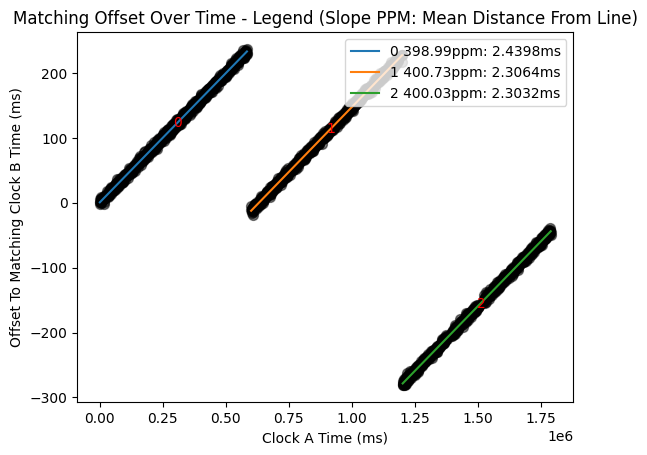

In [11]:
# Repopulate the original density output.
density_data = get_density_filtered_matches(signal_a_peak_times, signal_b_peak_times,
                                            match_indices_matrix,
                                            max_offset=None)
offset_t, offset_v = density_data['fine_offset_t'], density_data['fine_offset_v']

# Iterate the Robust Linear Regression
line_data = get_regression_lines(offset_t, offset_v)

# Filter the Results
line_data = get_filtered_lines(line_data)


# Plot the Results
plt.scatter(offset_t, offset_v, color='black', s=50, alpha=0.5)

for line_i, (start_time, end_time, (b, m), score, num_inliers) in enumerate(line_data):
    line_x = np.array([start_time, end_time], dtype=np.int64)
    line_y = (m * line_x) + b

    label = f"{line_i} {round(m * (10 ** 6), 2)}ppm: {round(score, 4)}ms"
    plt.plot(line_x, line_y, label=label)
    av_x = np.mean(line_x)
    av_y = np.mean(line_y)
    plt.text(av_x, av_y, str(line_i), c='red')

plt.legend(loc='upper right')
plt.title("Matching Offset Over Time - Legend (Slope PPM: Mean Distance From Line)")
plt.xlabel("Clock A Time (ms)")
plt.ylabel("Offset To Matching Clock B Time (ms)")

plt.show()

As we have been keeping track of the true offset between the two clocks, we can investigate how closely the algorithm
was able to detect the evolving offset between the Clocks.

Below we can plot the True Offset and The Detected offset in the same figure:

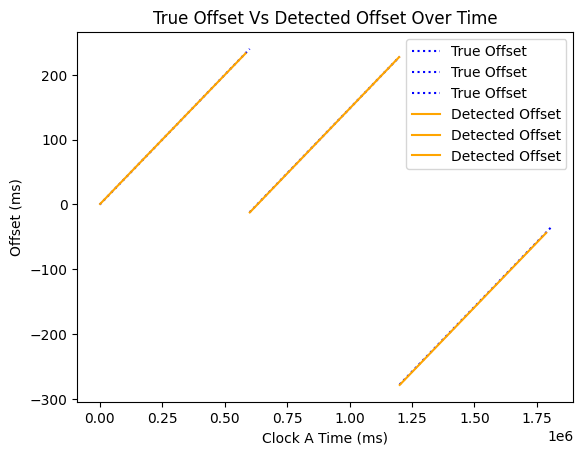

In [12]:
for line_i, (start_time, end_time, (b, m), _, _) in enumerate(true_line_data):
    line_x = np.array([start_time, end_time], dtype=np.int64)
    line_y = (m * line_x) + b
    plt.plot(line_x, line_y, linestyle='dotted', label="True Offset", color='blue')


for line_i, (start_time, end_time, (b, m), score, num_inliers) in enumerate(line_data):
    line_x = np.array([start_time, end_time], dtype=np.int64)
    line_y = (m * line_x) + b
    plt.plot(line_x, line_y, label="Detected Offset", color='orange')

plt.title("True Offset Vs Detected Offset Over Time")
plt.xlabel("Clock A Time (ms)")
plt.ylabel("Offset (ms)")
plt.legend()
plt.show()

We can also look at how the distance between truth and experiment evolves over time.

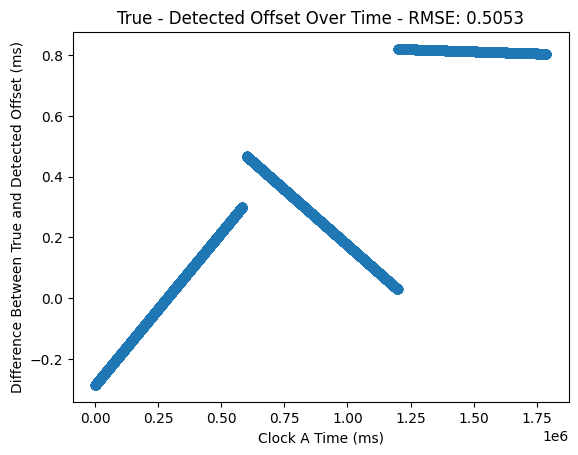

In [13]:
from sklearn.metrics import mean_squared_error
from tests.test_calculate_alignment import distances_between_lines

times, distances, actual, predicted = distances_between_lines(
    true_line_data, line_data, step_size=100)
rmse = mean_squared_error(actual, predicted, squared=False)

plt.title(f"True - Detected Offset Over Time - RMSE: {round(rmse, 4)}")
plt.scatter(times, distances)
plt.xlabel("Clock A Time (ms)")
plt.ylabel("Difference Between True and Detected Offset (ms)")
plt.show()

As you can see, the quality of the detected alignment signal comes directly from the performance of the Robust Linear
Regression output, and each regression line describes uncertainty in measurement differently.

You can check the `statisical_correctness.py` file to see some experiments in quantifying and explaining the variability
in uncertainty.

We also provide a function to map areas of alignment from Clock A to Clock B (or vice versa by swapping the arguments of the main function)

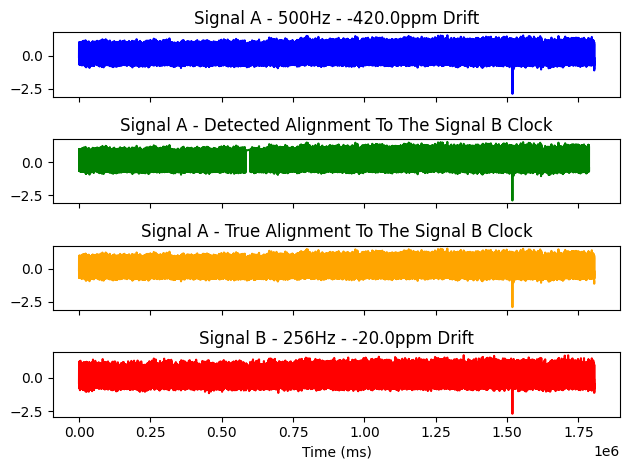

In [14]:
aligned_indices, aligned_original_times, alignment_corrected_times = \
        apply_alignment(false_a_t, line_data)

sorted_indices = alignment_corrected_times.argsort()

perf_aligned_indices, perf_aligned_original_times, perf_alignment_corrected_times = \
    apply_alignment(false_a_t, true_line_data)

perf_sorted_indices = perf_alignment_corrected_times.argsort()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True)

ax1.plot(false_a_t, resampled_a_x, color='blue')
ax1.set_title(f'Signal A - {freq_hz_a}Hz - {(10 ** 6) * clock_drift_a}ppm Drift')

ax2.plot(alignment_corrected_times[sorted_indices], resampled_a_x[aligned_indices][sorted_indices], color='green')
ax2.set_title('Signal A - Detected Alignment To The Signal B Clock')

ax3.plot(perf_alignment_corrected_times[perf_sorted_indices], resampled_a_x[perf_aligned_indices][perf_sorted_indices], color='orange')
ax3.set_title(f'Signal A - True Alignment To The Signal B Clock')

ax4.plot(false_b_t, resampled_b_x, color='red')
ax4.set_title(f'Signal B - {freq_hz_b}Hz - {(10 ** 6) * clock_drift_b}ppm Drift')

plt.xlabel('Time (ms)')

plt.tight_layout()
plt.show()


If we zoom in near one of the synchronization gaps, we can see a shortcoming of the current algorithm.
Since the window matches are tracked in time by the first beat of the window, the algorithm loses certainty
within 1 window size before a gap. A future version might improve upon this by tracking the entirety of the time
information encapsulated by a window.

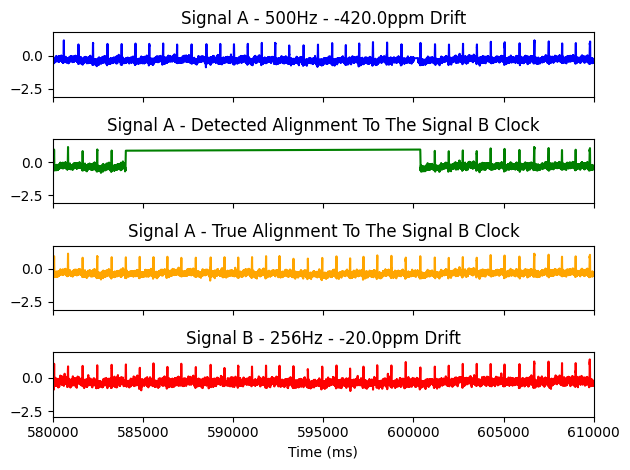

In [15]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True)

ax1.plot(false_a_t, resampled_a_x, color='blue')
ax1.set_title(f'Signal A - {freq_hz_a}Hz - {(10 ** 6) * clock_drift_a}ppm Drift')

ax2.plot(alignment_corrected_times[sorted_indices], resampled_a_x[aligned_indices][sorted_indices], color='green')
ax2.set_title('Signal A - Detected Alignment To The Signal B Clock')

ax3.plot(perf_alignment_corrected_times[perf_sorted_indices], resampled_a_x[perf_aligned_indices][perf_sorted_indices], color='orange')
ax3.set_title(f'Signal A - True Alignment To The Signal B Clock')

ax4.plot(false_b_t, resampled_b_x, color='red')
ax4.set_title(f'Signal B - {freq_hz_b}Hz - {(10 ** 6) * clock_drift_b}ppm Drift')

plt.xlabel('Time (ms)')
ax1.set_xlim(580000, 610000)

plt.tight_layout()
plt.show()

Zooming further in, we see that in regions where there is output from the algorithm, the alignment is excellent.

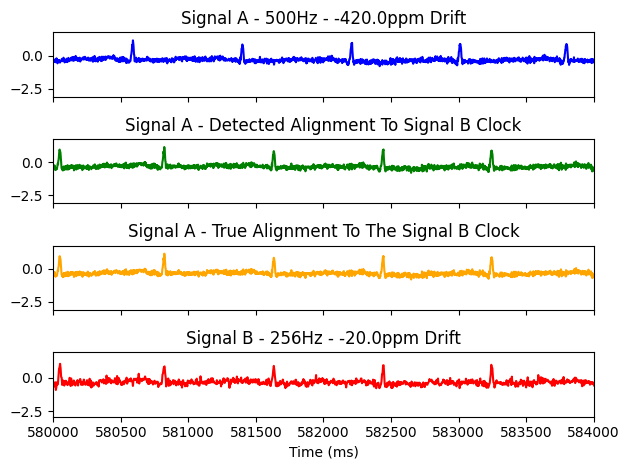

In [16]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True)

ax1.plot(false_a_t, resampled_a_x, color='blue')
ax1.set_title(f'Signal A - {freq_hz_a}Hz - {(10 ** 6) * clock_drift_a}ppm Drift')

ax2.plot(alignment_corrected_times[sorted_indices], resampled_a_x[aligned_indices][sorted_indices], color='green')
ax2.set_title('Signal A - Detected Alignment To Signal B Clock')

ax3.plot(perf_alignment_corrected_times[perf_sorted_indices], resampled_a_x[perf_aligned_indices][perf_sorted_indices], color='orange')
ax3.set_title(f'Signal A - True Alignment To The Signal B Clock')

ax4.plot(false_b_t, resampled_b_x, color='red')
ax4.set_title(f'Signal B - {freq_hz_b}Hz - {(10 ** 6) * clock_drift_b}ppm Drift')

plt.xlabel('Time (ms)')
ax1.set_xlim(580000, 584000)

plt.tight_layout()
plt.show()